**Raymond Yung**  
**Project 1**

In [1]:
import sys
# Scikit-Learn ≥0.20 is required
import sklearn
# Common imports
import numpy as np
import os

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)

In [3]:
X, y = mnist["data"].to_numpy(), mnist["target"].to_numpy()
y = y.astype(np.uint8)

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt

In [5]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")
#%%

## New attempt at this: 

One thing I forgot about last time was preprocessing the data. I did not normalize any of my data prior to this..
Soo let's preprocess this! Divide all my values by 255 (max value). 

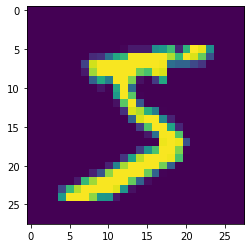

In [6]:
X /= 255;
X = np.expand_dims(X, 1)
plt.imshow(X[0].reshape(28,28)); ## Testing to confirm that it still works

In [7]:
def oneHotencode(data):
    array_length = len(range(min(data), max(data))) + 1;
    onehot_encode = list();
    for value in data:
        data_encoe = list()
        data_encode = [0 for _ in range(array_length)]
        data_encode[value] = 1;
        data_encode[value] = np.asarray(data_encode[value], np.float32)
        onehot_encode.append(data_encode);
    return np.asarray(onehot_encode, dtype = np.float32)

def oneHotdecode(encoded_data):
    decode = list()
    #for arr in encoded_data:
        #print(arr);
    decode.append(np.argmax(encoded_data))
    return np.asarray(decode, dtype = np.uint8)

In [8]:
y = oneHotencode(y)

c:\users\ry88\appdata\local\programs\python\python37\lib\site-packages\matplotlib\text.py:1215: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


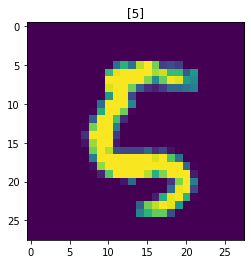

In [9]:
## Creating Training Set & Testing Set.
x_train = X[0:1500]
y_train = y[0:1500]
x_test = X[2000:3000]
y_test= y[2000:3000]
plt.imshow(x_test[0].reshape(28,28));
plt.title(oneHotdecode(y_test[0]));

I've tried 2 methods so far, each one led to overflow: 

1. Create 1 class, that included activation and softmax. 
    - Then created two layers from that, 1 for input layer and another for the hidden and output layer
2. Created 1 for loop that included all the layers thereby practically doing it manually. 
    - Led to the same issue.
    
Time to rethink my methodlogy:  
If I think about input/output, this is what's going on:
> **InputLayer -> HiddenLayer -> OutputLayer**
> - InputLayer: 
    - Takes in input nodes (784) returns activated nodes (32/64/128 in my case)
    - Contains its own weights and biases  
    
> - Hidden Layer:
    - Takes in activated output nodes from L1 (32/64/128)
    - Also contains its own weights and biases
    - Returns desidered output nodes (10).   
    
> - Output Layer: 
    - I don't think this is actually necessary... but the point of it is to convert the output nodes from the HiddenLayer into smething that we can understand.
        - Basically my softmax layer. 
        
Practically speaking, I should write my classes by proccess?

1. Class 1: X1 -> a1|z1 (Input Layer to Beginnning of Hidden Layer)
    - Includes Activation Function and returns activated nodes
2. Class 2: a1 -> Y1 (Hidden Layer to output layer). 
    - Includes softmax function and returns output nodes. 

This models the basic MLP function: 
> - Two Step Process: 
    - $ z_{1}^{(2)} = w_{11}^{(1)}x_{1} + w_{12}^{(1)}x_{2} + b_{1}^{(1)}$
        - $^{(i)}$ denotes the layer, with z being the output of the previous layer.
        - $w_{ii}$ denotes the weight at the current node
        - $x_{i}$ denotes the input   
    - Once Z is calculated, is it then immediately put in the activation function to calculate output a. Hence:
         - $a_{1}^{(2)} = f(z_{1}^{(2)})$
             - Where $f(z)$ is the activation function.  

In hindsight, looking at my model in this format, I think I could write 1 class and utilize it twice. Each instance will take an input of another function. Such that Class1 will also take the activation function and Class 2 will take the softmax function.   
  
**Update :** I want to add here the backward propogation issues I ran and debugged.   
I need to take into account the number of nodes as well that enters **and** exits the my (n-1) layers (this is what I call my first layer and hidden layer).  
I ran into an issue later on because I forgot that hidden layer's number of input nodes was 32, not 10. Since I combined with this my softmax layer, whos input and output nodes are both 10, it didn't occur ot me that this was the issue. 

In [10]:
## Start by writing my different functions: 

#Activation Functions
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_prime(x):
    return np.exp(-x) / (1 + np.exp(-x))**2

def tanh(x):
    return np.tanh(x)

def tanh_prime(x):
    return 1 - np.tanh(x)**2

def relu(x):
    return np.maximum(x, 0)

def relu_prime(x):
    return np.array(x >= 0).astype('int')


#Loss Functions:
def mse(y_true, y_pred):
    return np.mean(np.power(y_true - y_pred, 2))

def mse_prime(y_true, y_pred):
    return 2 * (y_pred - y_true) / y_pred.size

def sse(y_true, y_pred):
    return 0.5 * np.sum(np.power(y_true - y_pred, 2))

def sse_prime(y_true, y_pred):
    return y_pred - y_true


#Softmax Functions:

def softmax(input):
    tmp = np.exp(input)
    f_output = tmp/np.sum(tmp)
    return f_output

def softmax_prime(output_error, f_input_size, f_output):
    # Inputs:
        #Output_error from loss function
        #Forward Prop Input Size
        #output from forward prop softmax
    input_error = np.zeros(output_error.shape);
    out = np.tile(f_output.T, f_input_size)
    return f_output * np.dot(output_error, np.identity(f_input_size) - out)

In [11]:
#Creating Class Function for layers:

class Layers():
    def __init__(self, input_size, output_size, layer_num = 0):
        #Initialize Weights for these Input Layer and Hidden Layer
        self.input_size = input_size
        self.output_size = output_size
        self.weights = np.random.randn(input_size, output_size) / np.sqrt(input_size + output_size)
        self.bias = np.random.randn(1, output_size) / np.sqrt(input_size + output_size)
        self.layer_num = layer_num;
        
    def forward(self, input, funct):
        #Forward Prop... Needs to utilize softmax and activation.
        self.input = input
        self.a = np.dot(input, self.weights) + self.bias; #This is our a value.
        #funct is our activation and softmax function which both takes in 1 variable.
        #Remember, a is the input into the activation and softmax, which is what we will need again for the backward prop.
        if self.layer_num == 1:
            #Softmax Prime layer takes in input from softmax
            self.a = funct(self.a);
            return self.a
        else:
            return funct(self.a)
    
    def backwards(self, output_error, learning_rate, functp):
        #functp is our function to designate the backwards prop equations for both our activation function and our softmax function
        #At both of our layers here, softmax and activation came after, therefore it should come first in my backwards. 
        
        if self.layer_num == 0:
            #Activation Function at Process 1
            input_error = output_error * functp(self.a)
        if self.layer_num ==1:
            input_error = functp(output_error, self.output_size, self.a)
            
        ## Dealt with the activation and softmax prime layers. Now need to deal propogate this backwards
        # Our input errors are now our most recent output errors. Let's use this to propogate our weights. 
        [input_error, weights_error] = self.update_weights(input_error, learning_rate);
        self.weights -= learning_rate * weights_error
        self.bias -= learning_rate * output_error
        return input_error;
    
    def update_weights(self, input_error, learning_rate):
        #This is basically our n-1 layer, so the inputs our our self.input, not self.a. 
        input_error = np.dot(input_error, self.weights.T);
        weights_error = np.dot(self.input.T, output_error)
        return [input_error, weights_error];

In [12]:
# Create our our layers:

L1_XZ = Layers(784, 32, 0);
L2_ZY = Layers(32, 10, 1);

FC = [L1_XZ, L2_ZY];

In [13]:
#Test it.... 
error = 0;
learning_rate = 0.01;
for x, y_true in zip(x_train[0:500], y_train[0:500]):
    output = x;
    output = FC[0].forward(output, relu) #L -> Z;
    output = FC[1].forward(output, softmax) #Z2/L -> Y;
    # It works!
    error += sse(y_true, output);
    output_error = sse_prime(y_true, output);
    #backwards prop... work backwards
    output_error = FC[1].backwards(output_error, learning_rate, softmax_prime)
    #This should be returning my 32 nodes. 
    output_error = FC[0].backwards(output_error, learning_rate, relu_prime)
    
error /= len(x_train[0:500])
print(error)

0.4381973192689958


In [14]:
L1_XZ = Layers(784, 32, 0);
L2_ZY = Layers(32, 10, 1);

FC = [L1_XZ, L2_ZY];

In [15]:
epochs = 20;
learning_rate = 0.01;

for epoch in range(epochs):
    error = 0;
    for x, y_true in zip(x_train, y_train):
        output = x;
        output = FC[0].forward(output, sigmoid) #L -> Z;
        output = FC[1].forward(output, softmax) #Z2/L -> Y;
        # It works!
        error += sse(y_true, output);
        output_error = sse_prime(y_true, output);
        #backwards prop... work backwards
        output_error = FC[1].backwards(output_error, learning_rate, softmax_prime)
        #This should be returning my 32 nodes. 
        output_error = FC[0].backwards(output_error, learning_rate, sigmoid_prime)
    error /= len(x_train)
    print('%d/%d, error=%f' % (epoch + 1, epochs, error))

1/20, error=0.430169
2/20, error=0.331342
3/20, error=0.233195
4/20, error=0.183239
5/20, error=0.155614
6/20, error=0.135672
7/20, error=0.119726
8/20, error=0.106827
9/20, error=0.096906
10/20, error=0.089585
11/20, error=0.084060
12/20, error=0.079678
13/20, error=0.076072
14/20, error=0.073048
15/20, error=0.070481
16/20, error=0.068281
17/20, error=0.066377
18/20, error=0.064710
19/20, error=0.063227
20/20, error=0.061883


Alright! My code works! However, depending on which activation function I use, I have different maximums... When I train it once. 
If I use a sigmoid function, I have a maximum of 150 inputs, after that I run into overflow errors. This makes sense because I feel as though my errors are due to a vanishing gradient... Which results in my program giving overflows? I'm not too sure.  

The ReLu activation function allows me to get a maximum of 500 inputs, signicantly higher than what sigmoid did for me. However, I still get issues when it's larger than this. 

But let's test it! If it works, I will try to retrain my model using different batches.  
**Update: Model runs into issues after the first epoch, overflow errors occur.** 

**Update 2: Need to create 1 hot encoder for y**

**Update 3: Issue I was having was definitely due to the lack of a one hot encoder.... I'm an idiot**

Questions for later... Was I running into an issue for my other segments because I lacked a 1 hot encoder.... 
Okay! Well, I fixed a lot of issues in this version of the code and it works! I checked back on my previous versions and they stil fail regardless of my encoder.

**Update 3: Don't know why, but it does not like L2 Norm as a loss function.**
* Unless I'm doing something wrong, which could very much be the case, it does not like the L2 norm loss function, aka SSE, because i get values close to 0.  

# Success!
> After a good while, my model has finally worked! The culprit was not using a onehotencoder and a few other misdeeds. Now we can actually test different values, now that we now our model actually works!  

> - **Update** Kinda works, it really does not like sse loss function. So to save time, I will test with mse loss function
> - **Update 2** For some reason, sse + sigmoid will be alright if i don't run into that many epochs. I potentially might be running into an issue of over training?

### Discussions and Experiments

Upon testing, I've concluded that the ReLu on average performs better than sigmoid for this particular problem.  
Moving onwards, I now need to experiment with 3 different number of nodes, which as stated previously, I will try 32, 64, and 128. I choose this particular numbers because they are factors of each other and they just seem like good numbers.  

For each model, I want to take into account training and validation losses. Remember, I am currently using sse as my loss function, hence to calculate the validation loss, I am going to use the same loss function, except that it won't be used to update my weights.   
>  - **Update 3** This is interesting to note because I am now somewhat confident on my models. I run into the overflow errors when I have smaller amount of nodes. For example, when I run 32 nodes, I run into more overflow errors, and then at 64, I get the same error later, but farther down.
>  - **Update 4** Model does not like the ReLu and L2 loss combination. I get less errors when running sigmoid + sse. I can also conclude that the more layers I have, the less likely I run into the problem, which I believe is the vanishing gradient.

In [16]:
# 32 hidden nodes
model_1 = [Layers(784, 32, 0), Layers(32, 10, 1)]

epochs = 40;
learning_rate = 0.01;

Error_1 = list();
Validation_1 = list();
accuracy = 0;

for epoch in range(epochs):
    error = 0
    validation_error = 0
    for x, y_true in zip(x_train, y_train):
        output = x;
        output = model_1[0].forward(output, sigmoid) #L -> Z;
        output = model_1[1].forward(output, softmax) #Z2/L -> Y;
        # It works!
        error += sse(y_true, output);
        output_error = sse_prime(y_true, output);
        #backwards prop... work backwards
        output_error = model_1[1].backwards(output_error, learning_rate, softmax_prime)
        #This should be returning my 32 nodes. 
        output_error = model_1[0].backwards(output_error, learning_rate, sigmoid_prime)
    error /= len(x_train)
    Error_1.append(error)
    
    ## Validation
    for x, y_true in zip(x_test, y_test):
        output = x;
        output = model_1[0].forward(output, sigmoid) #L -> Z;
        output = model_1[1].forward(output, softmax) #Z2/L -> Y;
        validation_error += sse(y_true, output);
    validation_error /= len(x_test)
    Validation_1.append(validation_error)
    if epoch % 2 == 0:
        print('%d/%d, error=%f       val_error = %f' % (epoch + 2, epochs, error, validation_error))

2/40, error=0.421782       val_error = 0.369730
4/40, error=0.221116       val_error = 0.189208
6/40, error=0.147237       val_error = 0.139972
8/40, error=0.117529       val_error = 0.118605
10/40, error=0.098939       val_error = 0.106381
12/40, error=0.085799       val_error = 0.099746
14/40, error=0.076197       val_error = 0.096188
16/40, error=0.069157       val_error = 0.094177
18/40, error=0.063920       val_error = 0.093129
20/40, error=0.059937       val_error = 0.092647
22/40, error=0.056764       val_error = 0.092476
24/40, error=0.054065       val_error = 0.092469
26/40, error=0.051646       val_error = 0.092486
28/40, error=0.049481       val_error = 0.092413
30/40, error=0.047574       val_error = 0.092279
32/40, error=0.045860       val_error = 0.092151
34/40, error=0.044286       val_error = 0.092084
36/40, error=0.042818       val_error = 0.092120
38/40, error=0.041443       val_error = 0.092279
40/40, error=0.040132       val_error = 0.092542


In [17]:
#64 hidden nodes
model_2 = [Layers(784, 64, 0), Layers(64, 10, 1)]

epochs = 40;
learning_rate = 0.01;
Error_2 = list();
Validation_2 = list();

for epoch in range(epochs):
    error = 0
    validation_error = 0
    for x, y_true in zip(x_train, y_train):
        output = x;
        output = model_2[0].forward(output, sigmoid) #L -> Z;
        output = model_2[1].forward(output, softmax) #Z2/L -> Y;
        # It works!
        error += sse(y_true, output);
        output_error = sse_prime(y_true, output);
        #backwards prop... work backwards
        output_error = model_2[1].backwards(output_error, learning_rate, softmax_prime)
        #This should be returning my 32 nodes. 
        output_error = model_2[0].backwards(output_error, learning_rate, sigmoid_prime)
    error /= len(x_train)
    Error_2.append(error)
        
    for x, y_true in zip(x_test, y_test):
        output = x;
        output = model_2[0].forward(output, sigmoid) #L -> Z;
        output = model_2[1].forward(output, softmax) #Z2/L -> Y;
        validation_error += sse(y_true, output);
    validation_error /= len(x_test)
    Validation_2.append(validation_error)
    if epoch % 2 == 0:
        print('%d/%d, error=%f       val_error = %f' % (epoch + 2, epochs, error, validation_error))

2/40, error=0.417925       val_error = 0.350091
4/40, error=0.186273       val_error = 0.151967
6/40, error=0.113526       val_error = 0.108916
8/40, error=0.087961       val_error = 0.093192
10/40, error=0.074595       val_error = 0.085779
12/40, error=0.065746       val_error = 0.082192
14/40, error=0.059007       val_error = 0.080428
16/40, error=0.053557       val_error = 0.079499
18/40, error=0.049062       val_error = 0.078972
20/40, error=0.045325       val_error = 0.078718
22/40, error=0.042134       val_error = 0.078684
24/40, error=0.039318       val_error = 0.078815
26/40, error=0.036788       val_error = 0.079068
28/40, error=0.034504       val_error = 0.079424
30/40, error=0.032396       val_error = 0.079887
32/40, error=0.030419       val_error = 0.080475
34/40, error=0.028558       val_error = 0.081189
36/40, error=0.026807       val_error = 0.081974
38/40, error=0.025187       val_error = 0.082776
40/40, error=0.023687       val_error = 0.083581


In [18]:
#128 hidden nodes
model_3 = [Layers(784, 128, 0), Layers(128, 10, 1)]

epochs = 40;
learning_rate = 0.01;

Error_3 = list();
Validation_3 = list();

for epoch in range(epochs):
    error = 0;
    validation_error = 0
    for x, y_true in zip(x_train, y_train):
        output = x;
        output = model_3[0].forward(output, sigmoid) #L -> Z;
        output = model_3[1].forward(output, softmax) #Z2/L -> Y;
        # It works!
        error += sse(y_true, output);
        output_error = sse_prime(y_true, output);
        #backwards prop... work backwards
        output_error = model_3[1].backwards(output_error, learning_rate, softmax_prime)
        #This should be returning my 32 nodes. 
        output_error = model_3[0].backwards(output_error, learning_rate, sigmoid_prime)
    error /= len(x_train)
    Error_3.append(error)
    for x, y_true in zip(x_test, y_test):
        output = x;
        output = model_3[0].forward(output, sigmoid) #L -> Z;
        output = model_3[1].forward(output, softmax) #Z2/L -> Y;
        validation_error += sse(y_true, output);
    validation_error /= len(x_test)
    Validation_3.append(validation_error)
    if epoch % 2 == 0:
        print('%d/%d, error=%f       val_error = %f' % (epoch + 2, epochs, error, validation_error))

2/40, error=0.415794       val_error = 0.330627
4/40, error=0.170397       val_error = 0.139328
6/40, error=0.106608       val_error = 0.101563
8/40, error=0.084371       val_error = 0.088962
10/40, error=0.072241       val_error = 0.083723
12/40, error=0.063964       val_error = 0.081247
14/40, error=0.057578       val_error = 0.079974
16/40, error=0.052301       val_error = 0.079221
18/40, error=0.047856       val_error = 0.078730
20/40, error=0.044098       val_error = 0.078501
22/40, error=0.040892       val_error = 0.078535
24/40, error=0.038146       val_error = 0.078725
26/40, error=0.035778       val_error = 0.078954
28/40, error=0.033695       val_error = 0.079177
30/40, error=0.031834       val_error = 0.079375
32/40, error=0.030161       val_error = 0.079554
34/40, error=0.028643       val_error = 0.079753
36/40, error=0.027245       val_error = 0.080037
38/40, error=0.025935       val_error = 0.080474
40/40, error=0.024648       val_error = 0.081103


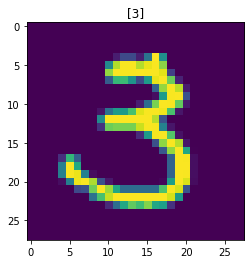

In [19]:
#Let's test our models. 
image_test = X[4001:4002];
y_true_test = oneHotdecode(y[4001:4002])
plt.imshow(image_test.reshape(28,28));
plt.title(y_true_test);

In [20]:
output = model_3[0].forward(image_test, sigmoid) #L -> Z;
output = model_3[1].forward(output, softmax) #Z2/L -> Y;

In [21]:
val = output[0]
oneHotdecode(val)

array([3], dtype=uint8)

# Success! 
Our model works! Tested all 3, each predicted this model. However, we can see from our validation tests above that overfitting happens quite often, as our validation error begins to increase after 25 iterations when using 128 nodes. We run into this issue more often when we use less nodes.  
  
That being said, let's plot our differnt validation and error losses...  

In [22]:
def plot_errors(error_loss, validation_loss, num_model):
    plt.figure
    plt.plot(error_loss, linewidth = 2);
    plt.plot(validation_loss, linewidth = 2);
    plt.legend(labels = ['Training Loss', 'Validation Loss'])
    plt.title(num_model)

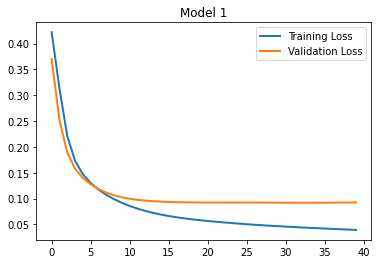

In [23]:
plot_errors(Error_1, Validation_1, 'Model 1')

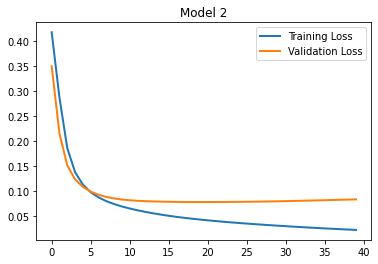

In [24]:
plot_errors(Error_2, Validation_2, 'Model 2')

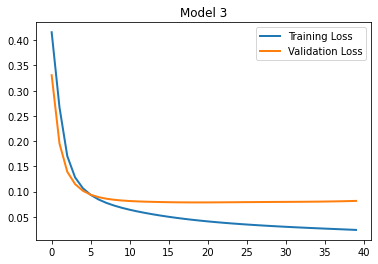

In [25]:
plot_errors(Error_3, Validation_3, 'Model 3')

## Discussion
Looking at our plots above, we can see our validation loss slowly increasing, if not staying stagnant at a certain point. This tells us that our model is overfitting. Frankly, we didn't need to graph this to see it, as we can see the validation loss when we trained our models.  

That being said, we can now create a better model, one that takes into account overfitting. Basically, we will break out of our training when our validation loss starts to increase. Furthermore, as I've stated earlier, having 32 to 64 nodes in combination with 1000 training points resulted in data overflow in my model. So for my 'better' model, I will try it with 256 nodes. If it works well, I'll test it with a larger dataset

In [26]:
x_train = X[0:8000]
y_train = y[0:8000]
x_test = X[11000:14500]
y_test= y[11000:14500]

In [27]:
from copy import deepcopy

final_model = [Layers(784, 256, 0), Layers(256, 10, 1)]

epochs = 40;
learning_rate = 0.01;

Error_4 = list();
Validation_4 = list();
tmp_m1 = None;
tmp_m2 = None;
tmp_m3 = None;
for epoch in range(epochs):
    error = 0;
    validation_error = 0
    for x, y_true in zip(x_train, y_train):
        output = x;
        output = final_model[0].forward(output, sigmoid) #L -> Z;
        output = final_model[1].forward(output, softmax) #Z2/L -> Y;
        # It works!
        error += sse(y_true, output);
        output_error = sse_prime(y_true, output);
        #backwards prop... work backwards
        output_error = final_model[1].backwards(output_error, learning_rate, softmax_prime)
        #This should be returning my 32 nodes. 
        output_error = final_model[0].backwards(output_error, learning_rate, sigmoid_prime)
    error /= len(x_train)
    Error_4.append(error)
    for x, y_true in zip(x_test, y_test):
        output = x;
        output = final_model[0].forward(output, sigmoid) #L -> Z;
        output = final_model[1].forward(output, softmax) #Z2/L -> Y;
        validation_error += sse(y_true, output);
    validation_error /= len(x_test)
    Validation_4.append(validation_error)
    
    val_average = np.mean(np.array(Validation_4[-5:]));
    #if (epoch+1) % 2 == 0:
    print('%d/%d, error=%f       val_error = %f' % (epoch + 1, epochs, error, validation_error))
    
    if (validation_error > val_average) and len(Validation_4) > 4:
        if np.argmin(Validation_4[-5:]) == 0:
            ep = epoch - 3
            final_model = deepcopy(tmp_m4)
        elif np.argmin(Validation_4[-5:])== 1:
            ep = epoch - 2
            final_model = deepcopy(tmp_m3)
        elif np.argmin(Validation_4[-5:]) == 2:
            ep = epoch - 1
            final_model = deepcopy(tmp_m2);
        elif np.argmin(Validation_4[-5:]) == 3:
            ep = epoch 
            final_model = deepcopy(tmp_m1);
        else:
            ep = epoch + 1

        print("Overfitting Detected -- Regress back to Model at epoch %d" % ep)
        break
    #Save 4 iterations of our model
    if tmp_m1 != None:
        if tmp_m2 != None:
            if tmp_m3 != None:
                tmp_m4 = deepcopy(tmp_m3) #model N-4
            tmp_m3 = deepcopy(tmp_m2); #Model N-3;
        tmp_m2 = deepcopy(tmp_m1 ); #Model N-2
    tmp_m1 = deepcopy(final_model) #Model N-1
    

1/40, error=0.201824       val_error = 0.111767
2/40, error=0.082046       val_error = 0.098021
3/40, error=0.069079       val_error = 0.094184
4/40, error=0.062580       val_error = 0.091603
5/40, error=0.058187       val_error = 0.089719
6/40, error=0.054878       val_error = 0.088461
7/40, error=0.052253       val_error = 0.087606
8/40, error=0.050083       val_error = 0.086976
9/40, error=0.048225       val_error = 0.086485
10/40, error=0.046595       val_error = 0.086085
11/40, error=0.045143       val_error = 0.085736
12/40, error=0.043836       val_error = 0.085407
13/40, error=0.042650       val_error = 0.085091
14/40, error=0.041568       val_error = 0.084799
15/40, error=0.040574       val_error = 0.084548
16/40, error=0.039655       val_error = 0.084350
17/40, error=0.038798       val_error = 0.084216
18/40, error=0.037994       val_error = 0.084152
19/40, error=0.037240       val_error = 0.084154
20/40, error=0.036533       val_error = 0.084217
21/40, error=0.035863       v

In [28]:
#Test the validation score on a completely different dataset that is differnt from my testing
x_val = X[50000:60000]
y_val= y[50000:60000]
for x, y_true in zip(x_val, y_val):
    output = x;
    output = final_model[0].forward(output, sigmoid) #L -> Z;
    output = final_model[1].forward(output, softmax) #Z2/L -> Y;
    validation_error += sse(y_true, output);
validation_error /= len(x_test)
print("Val Loss : ", validation_error)

Val Loss :  0.20054478908775805


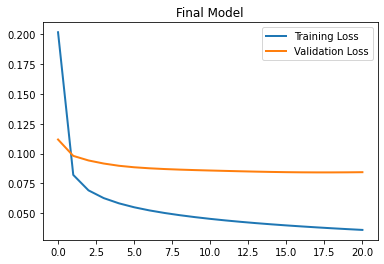

In [29]:
plot_errors(Error_4[0:40], Validation_4[0:40], 'Final Model')

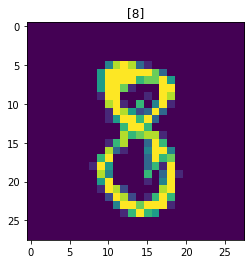

In [30]:
test_image = x_val[48:49]
test_label = y_val[48:49]
plt.imshow(test_image.reshape(28,28));
plt.title(oneHotdecode(test_label));

In [31]:
output = final_model[0].forward(test_image, sigmoid) #L -> Z;
output = final_model[1].forward(output, softmax) #Z2/L -> Y;
predict_image = oneHotdecode(output[0]);
print(predict_image)

[8]


# Conclusion: 
My final model runs above a 90% accuracy on a validation dataset that is different from my testing datset. I wanted to also note that my final model breaks out of training when the most recent validation accuracy score is greater than the average of the last 5 scores, including the current one. Then, it seeks out the best model that performed during those iterations. By doing the average of the last few scores, we take into account if the most recent validation score is an outlier. If the validation scores are steadily going up (thus giving proof that overfitting is occuring), we would still be able to break out of training as that would mean the most recent score is still larger than the average of the previous set of scores.  

  
I tested my final model again on a new validation set, one that is completely different from my testing set and I achive similar result having achieved above a 90% accuracy!

> ### References :
> - https://machinelearningmastery.com/implement-perceptron-algorithm-scratch-python/
> - https://colab.research.google.com/drive/10y6glU28-sa-OtkeL8BtAtRlOITGMnMw#scrollTo=rXY7jkUzuqEk
> - https://towardsdatascience.com/math-neural-network-from-scratch-in-python-d6da9f29ce65